In [1]:
# pip install medmnist # if pipenv install doesn't work.

In [2]:
from medmnist import PneumoniaMNIST

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K, regularizers
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import class_weight
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random

In [3]:
train_dataset = PneumoniaMNIST(split="train", download=True)
validation_dataset = PneumoniaMNIST(split="val", download=True)
test_dataset = PneumoniaMNIST(split="test", download=True)

In [4]:
train_dataset


Dataset PneumoniaMNIST of size 28 (pneumoniamnist)
    Number of datapoints: 4708
    Root location: C:\Users\bigma\.medmnist
    Split: train
    Task: binary-class
    Number of channels: 1
    Meaning of labels: {'0': 'normal', '1': 'pneumonia'}
    Number of samples: {'train': 4708, 'val': 524, 'test': 624}
    Description: The PneumoniaMNIST is based on a prior dataset of 5,856 pediatric chest X-Ray images. The task is binary-class classification of pneumonia against normal. We split the source training set with a ratio of 9:1 into training and validation set and use its source validation set as the test set. The source images are gray-scale, and their sizes are (384−2,916)×(127−2,713). We center-crop the images and resize them into 1×28×28.
    License: CC BY 4.0

In [5]:
type(train_dataset)

medmnist.dataset.PneumoniaMNIST

In [6]:
img, label = train_dataset[0]
print(f"Type of image: {type(img)}")
# print(f"Shape of image: {img.shape}")

Type of image: <class 'PIL.Image.Image'>


In [7]:
# based on Windsurf prompt: "how to convert PIL.Image.Image to a numpy array"

# Get a sample image from the dataset
img, label = train_dataset[0]  # Get first sample

x_train = np.array(img)

print(f"Shape of numpy array: {x_train.shape}")

Shape of numpy array: (28, 28)


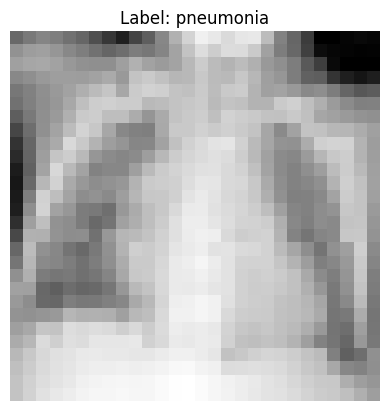

Pixel values:
[ 92 108 117 111 101  90  70  49  28  60  83 119 156 186 211 204 192 203
 204 166 115  90  53   0   0   5   8   6]


In [8]:
# based on Windsurf prompt: "how to plot the first sample image from train_dataset"

# Get the first sample
img_tensor, label = train_dataset[0]

# Convert tensor to numpy array
img_array = np.array(img_tensor)

# Plot the image
plt.imshow(img_array, cmap='gray')  # Use cmap='gray' for grayscale images
plt.title(f"Label: {'pneumonia' if label.item() == 1 else 'normal'}")
plt.axis('off')  # Hide axis
plt.show()

# If you want to see the raw pixel values
print("Pixel values:")
print(img_array[0])

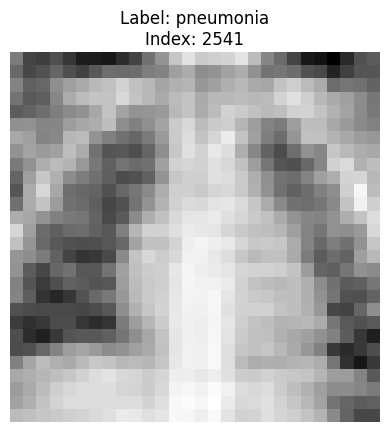

Image shape: (28, 28)
Label (0=normal, 1=pneumonia): 1


In [9]:
# based on Windsurf prompt: "how to plot a random image from train_dataset"

# Get a random index
random_idx = random.randint(0, len(train_dataset) - 1)

# Get the random sample
img_tensor, label = train_dataset[random_idx]

# Convert tensor to numpy array
img_array = np.array(img_tensor)

# Plot the image
plt.imshow(img_array, cmap='gray')
plt.title(f"Label: {'pneumonia' if label.item() == 1 else 'normal'}\nIndex: {random_idx}") # Index: 3485 on a prior run.
plt.axis('off')
plt.show()

# Print additional info about the sample
print(f"Image shape: {img_array.shape}")
print(f"Label (0=normal, 1=pneumonia): {label.item()}")

In [10]:
train_dataset

Dataset PneumoniaMNIST of size 28 (pneumoniamnist)
    Number of datapoints: 4708
    Root location: C:\Users\bigma\.medmnist
    Split: train
    Task: binary-class
    Number of channels: 1
    Meaning of labels: {'0': 'normal', '1': 'pneumonia'}
    Number of samples: {'train': 4708, 'val': 524, 'test': 624}
    Description: The PneumoniaMNIST is based on a prior dataset of 5,856 pediatric chest X-Ray images. The task is binary-class classification of pneumonia against normal. We split the source training set with a ratio of 9:1 into training and validation set and use its source validation set as the test set. The source images are gray-scale, and their sizes are (384−2,916)×(127−2,713). We center-crop the images and resize them into 1×28×28.
    License: CC BY 4.0

In [11]:
# based on Windsurf prompt: "how to get a numpy ndarray of x_train images and y_train labels from train_dataset of type medmnist.dataset.PneumoniaMNIST"

# Initialize lists to store images and labels
images = []
labels = []

# Loop through the dataset
for img_tensor, label in train_dataset:
    # Convert tensor to numpy array and append
    images.append(np.array(img_tensor))
    labels.append(label.item())  # Convert tensor to scalar

# Convert lists to numpy arrays
x_train = np.stack(images)  # Stack images into a single array
y_train = np.array(labels)  # Convert labels list to array

x_train = np.expand_dims(x_train, axis=-1)

# Check shapes
print(f"x_train shape: {x_train.shape}")  # Should be (4708, 28, 28, 1)
print(f"y_train shape: {y_train.shape}")  # Should be (4708,)

# TODO: If you want to flatten the images for machine learning
# x_train_flattened = x_train.reshape(x_train.shape[0], -1)  # Shape will be (4708, 784)

x_train shape: (4708, 28, 28, 1)
y_train shape: (4708,)


In [12]:
# Initialize lists to store images and labels
images = []
labels = []

# Loop through the dataset
for img_tensor, label in validation_dataset:
    # Convert tensor to numpy array and append
    images.append(np.array(img_tensor))
    labels.append(label.item())  # Convert tensor to scalar

# Convert lists to numpy arrays
x_validation = np.stack(images)  # Stack images into a single array
y_validation = np.array(labels)  # Convert labels list to array

x_validation = np.expand_dims(x_validation, axis=-1)

# Check shapes
print(f"x_validation shape: {x_validation.shape}")  # Should be (4708, 28, 28, 1)
print(f"y_validation shape: {y_validation.shape}")  # Should be (4708,)

x_validation shape: (524, 28, 28, 1)
y_validation shape: (524,)


In [13]:
images = []
labels = []
 
# Loop through the dataset
for img_tensor, label in test_dataset:
    # Convert tensor to numpy array and append
    images.append(np.array(img_tensor))
    labels.append(label.item())  # Convert tensor to scalar
 
# Convert lists to numpy arrays
x_test = np.stack(images)  # Stack images into a single array
y_test = np.array(labels)  # Convert labels list to array
 
x_test = np.expand_dims(x_test, axis=-1)

In [14]:
# Normalize image pixel values to [0, 1]
if x_train.max() > 1:
    x_train = x_train.astype(np.float32) / 255.0
    
if x_validation.max() > 1:
    x_validation = x_validation.astype(np.float32) / 255.0

if x_test.max() > 1:
    x_test = x_test.astype(np.float32) / 255.0

Class distribution in y_train:
Class normal (label 0): 1214 samples
Class pneumonia (label 1): 3494 samples

Using pandas:
1    3494
0    1214
Name: count, dtype: int64
1    74.214104
0    25.785896
Name: proportion, dtype: float64
Axes(0.125,0.11;0.775x0.77)


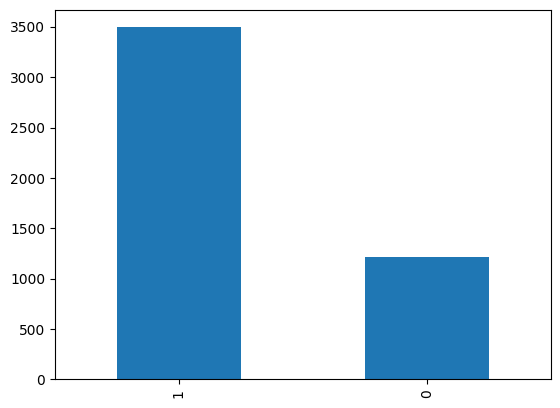

In [15]:
def show_class_distribution(dataset, dataset_name):
    # Get unique values and their counts
    unique_values, counts = np.unique(dataset, return_counts=True)

    # Create a dictionary of counts
    class_counts = dict(zip(unique_values, counts))

    # Print the counts
    print(f"Class distribution in {dataset_name}:")
    for class_id, count in class_counts.items():
        class_name = 'normal' if class_id == 0 else 'pneumonia'
        print(f"Class {class_name} (label {class_id}): {count} samples")

    # Alternative way using pandas
    import pandas as pd
    dataset_df = pd.Series(dataset)
    print("\nUsing pandas:")
    print(dataset_df.value_counts())
    percentage_df = dataset_df.value_counts(normalize=True) * 100
    print(percentage_df)
    print(dataset_df.value_counts().plot(kind='bar'))

show_class_distribution(y_train, "y_train")

Class distribution in y_validation:
Class normal (label 0): 135 samples
Class pneumonia (label 1): 389 samples

Using pandas:
1    389
0    135
Name: count, dtype: int64
1    74.236641
0    25.763359
Name: proportion, dtype: float64
Axes(0.125,0.11;0.775x0.77)


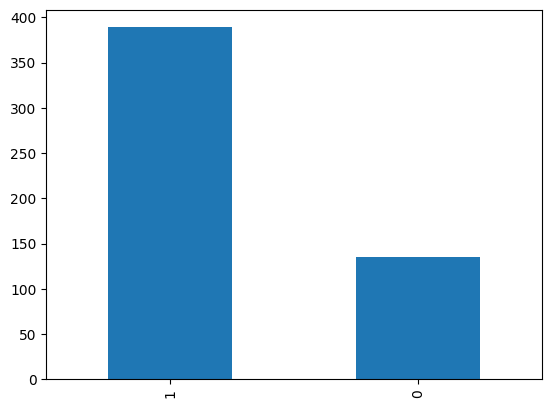

In [16]:
show_class_distribution(y_validation, "y_validation")

Class distribution in y_test:
Class normal (label 0): 234 samples
Class pneumonia (label 1): 390 samples

Using pandas:
1    390
0    234
Name: count, dtype: int64
1    62.5
0    37.5
Name: proportion, dtype: float64
Axes(0.125,0.11;0.775x0.77)


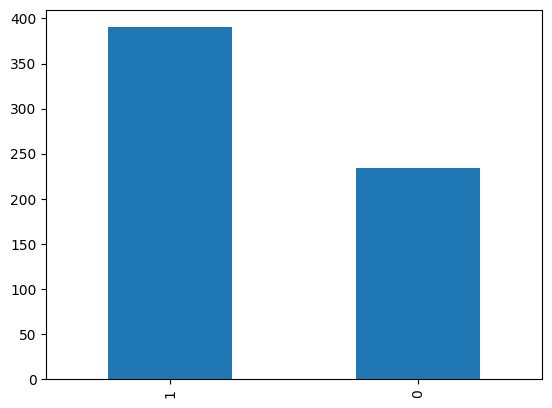

In [17]:
show_class_distribution(y_test, "y_test")

In [18]:
print(x_train.shape)
print(y_train.shape)
print(x_validation.shape)
print(y_validation.shape)


(4708, 28, 28, 1)
(4708,)
(524, 28, 28, 1)
(524,)


## Baseline implementation -- Fully Connected DNN

Uses a dense neural network with 2 hidden layers of 8 neurons each, like from early DNN examples from class and like projects 2 and 3.

These choices led to a trainable parameter count of 6361, which is larger than the number of images in the training set (4708).

In [19]:
# Set random seeds for reproducibility
random.seed(42) # Set Python random seed
tf.random.set_seed(42)
np.random.seed(42)

model = Sequential([
    Input(shape=(28, 28, 1)),
    Flatten(),
    Dense(8, activation='relu'),
    Dense(8, activation='relu'), # TODO: Try with more or fewer hidden layers and neurons.
    Dense(1, activation='sigmoid')]) # sigmoid for binary classification.

# TODO: Consider trying BinaryFocalCrossentropy also: https://keras.io/api/losses/probabilistic_losses/#binaryfocalcrossentropy-class
model.compile(loss='binary_crossentropy',optimizer=Adam(),metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │         6,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │            72 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,361 (24.85 KB)

 Trainable params: 6,361 (24.85 KB)

 Non-trainable params: 0 (0.00 B)

In [20]:
history = model.fit(x_train, y_train, epochs=10, validation_data=(x_validation, y_validation))

Epoch 1/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7612 - loss: 0.5021 - val_accuracy: 0.8836 - val_loss: 0.2854
Epoch 2/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8999 - loss: 0.2627 - val_accuracy: 0.9332 - val_loss: 0.2044
Epoch 3/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9142 - loss: 0.2090 - val_accuracy: 0.9447 - val_loss: 0.1766
Epoch 4/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9230 - loss: 0.1892 - val_accuracy: 0.9523 - val_loss: 0.1613
Epoch 5/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9281 - loss: 0.1774 - val_accuracy: 0.9504 - val_loss: 0.1514
Epoch 6/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9303 - loss: 0.1700 - val_accuracy: 0.9523 - val_loss: 0.1448
Epoch 7/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9343 - loss: 0.1646 - val_accuracy: 0.9561 - val_loss: 0.1401
Epoch 8/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9354 - loss: 0.1605 - val_accuracy: 0.

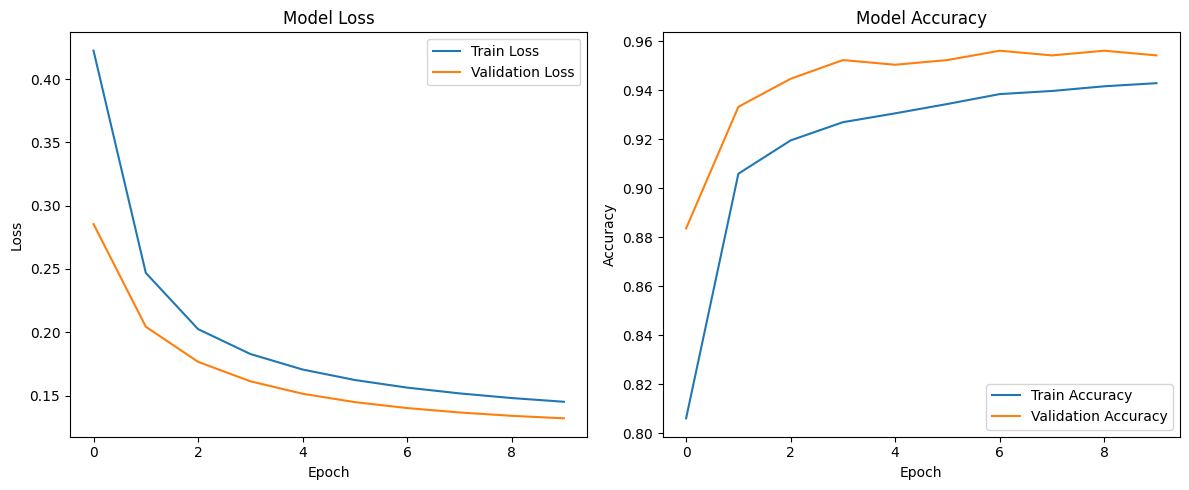

In [21]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
# Plot training & validation loss values
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [22]:
# from Prof:
# Try CNN
# TODO: try classical machine learning such as random forest.
# try increasing the size of the testing dataset and decreasing the size of the training dataset.
# if we add noise to the images, can we still predict pneumonia?

# Presenting the 2nd day of week 12, last day of lecture, 8/14/2025.

In [23]:
# global results_df
results_df = pd.DataFrame(columns=['model', 'test_accuracy', 'train_accuracy', 'val_accuracy'])

def test_model_and_evaluate(model, model_name):
    # Predict probabilities for the test set
    y_pred_prob = model.predict(x_test)
    print(f"Predicted probabilities shape: {y_pred_prob.shape}")

    # Convert probabilities to binary labels using a threshold of 0.5
    y_pred_classes = (y_pred_prob > 0.5).astype(int).flatten()

    # Evaluate the model on the test set
    test_loss, test_accuracy = model.evaluate(x_test, y_test)
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    global results_df
    model_accuracy_dict = {'model': model_name, 'test_accuracy': test_accuracy, 'train_accuracy': history.history['accuracy'][-1], 'val_accuracy': history.history['val_accuracy'][-1]}
    results_df = pd.concat([results_df, pd.DataFrame(model_accuracy_dict, index=[0])], ignore_index=True)

    # Print a classification report (precision, recall, F1-score per class)
    print("Classification Report:")
    print(classification_report(y_test, y_pred_classes))

    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred_classes)

    # Visualize the confusion matrix using seaborn heatmap
    plt.figure(figsize=(7, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Pneumonia'], yticklabels=['Normal', 'Pneumonia'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

    # Calculate per-class accuracy
    per_class_accuracy = np.diagonal(cm) / np.sum(cm, axis=1)

    print("Per-class Accuracy:")
    for i, accuracy in enumerate(per_class_accuracy):
        class_name = 'Normal' if i == 0 else 'Pneumonia'
        print(f"Class {class_name}: {accuracy:.4f}")

    print(f"\nResults:\n{results_df}")

def print_accuracy_and_loss(history): 
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    # Plot training & validation loss values
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [24]:
import warnings
warnings.filterwarnings('ignore')

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Predicted probabilities shape: (624, 1)
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8287 - loss: 0.5455 
Test Loss: 0.5112
Test Accuracy: 0.8349
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.59      0.73       234
           1       0.80      0.98      0.88       390

    accuracy                           0.83       624
   macro avg       0.88      0.79      0.80       624
weighted avg       0.86      0.83      0.82       624



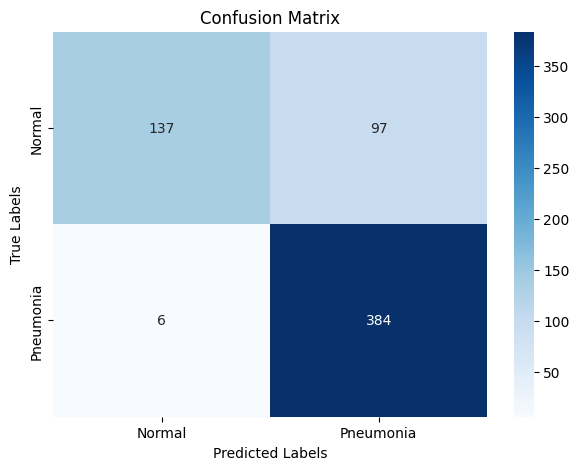

Per-class Accuracy:
Class Normal: 0.5855
Class Pneumonia: 0.9846

Results:
          model  test_accuracy  train_accuracy  val_accuracy
0  baseline DNN       0.834936        0.942863      0.954198


In [25]:
test_model_and_evaluate(model, "baseline DNN") # Test Accuracy: 0.8349

## Optimization Attempts -- CNNs

In [26]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(15, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(),
    metrics=['accuracy']
)

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 24, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 15)             │       138,255 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            16 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 157,087 (613.62 KB)

 Trainable params: 157,087 (613.62 KB)

 Non-trainable params: 0 (0.00 B)

In [27]:
history = model.fit(x_train, y_train, epochs=10, validation_data=(x_validation, y_validation))

Epoch 1/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8028 - loss: 0.4326 - val_accuracy: 0.9218 - val_loss: 0.1949
Epoch 2/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9166 - loss: 0.1962 - val_accuracy: 0.9523 - val_loss: 0.1254
Epoch 3/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9324 - loss: 0.1570 - val_accuracy: 0.9580 - val_loss: 0.1112
Epoch 4/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9452 - loss: 0.1471 - val_accuracy: 0.9599 - val_loss: 0.1016
Epoch 5/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9512 - loss: 0.1358 - val_accuracy: 0.9618 - val_loss: 0.0987
Epoch 6/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9561 - loss: 0.1236 - val_accuracy: 0.9599 - val_loss: 0.0911
Epoch 7/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9552 - loss: 0.1129 - val_accuracy: 0.9599 - val_loss: 0.0899
Epoch 8/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9545 - loss: 0.1081 - val_accuracy: 0.

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Predicted probabilities shape: (624, 1)
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8679 - loss: 0.5870
Test Loss: 0.5316
Test Accuracy: 0.8670
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.67      0.79       234
           1       0.83      0.98      0.90       390

    accuracy                           0.87       624
   macro avg       0.90      0.83      0.85       624
weighted avg       0.88      0.87      0.86       624



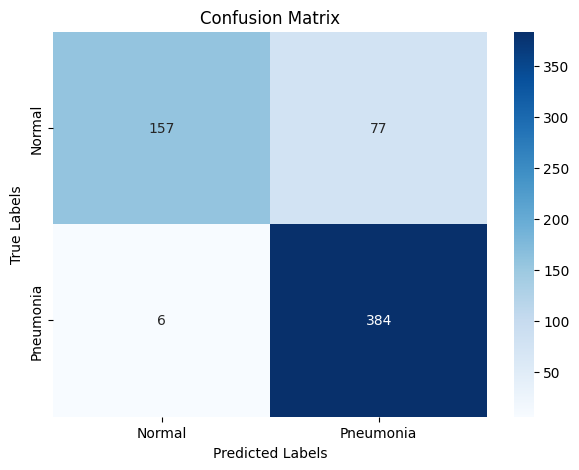

Per-class Accuracy:
Class Normal: 0.6709
Class Pneumonia: 0.9846

Results:
          model  test_accuracy  train_accuracy  val_accuracy
0  baseline DNN       0.834936        0.942863      0.954198
1  baseline CNN       0.866987        0.970263      0.965649


In [28]:
test_model_and_evaluate(model, "baseline CNN") # Test Accuracy: 0.8670

In [29]:
# To GitHub Copilot Chat:
# "I'm still only performing at 80% accuracy on testing data with poor false positive performance. Update the CNN architecture to try and improve detection"

# Previous was:
# model = Sequential([
#     Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
#     Conv2D(64, (3, 3), activation='relu'),
#     MaxPooling2D(pool_size=(2, 2)),
#     Flatten(),
#     Dense(15, activation='relu'),
#     Dense(1, activation='sigmoid')
# ])

# model.compile(
#     loss='binary_crossentropy',
#     optimizer=Adam(),
#     metrics=['accuracy']
# )


# This adds Dropout, another Conv2D layer, Dropout, a dense layer of 256 units, and Dropout before the final layer.
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=0.0001),
    metrics=['accuracy']
)

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 10, 10, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 5, 5, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 5, 5, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 3200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │       819,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 912,385 (3.48 MB)

 Trainable params: 912,385 (3.48 MB)

 Non-trainable params: 0 (0.00 B)

In [30]:
history = model.fit(x_train, y_train, epochs=10, validation_data=(x_validation, y_validation))

Epoch 1/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.7201 - loss: 0.5684 - val_accuracy: 0.8989 - val_loss: 0.4198
Epoch 2/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.8662 - loss: 0.3225 - val_accuracy: 0.8836 - val_loss: 0.2844
Epoch 3/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.9003 - loss: 0.2296 - val_accuracy: 0.8893 - val_loss: 0.2587
Epoch 4/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9095 - loss: 0.2170 - val_accuracy: 0.8931 - val_loss: 0.2453
Epoch 5/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9143 - loss: 0.1983 - val_accuracy: 0.8798 - val_loss: 0.2698
Epoch 6/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.9206 - loss: 0.1871 - val_accuracy: 0.8874 - val_loss: 0.2637
Epoch 7/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.9267 - loss: 0.1792 - val_accuracy: 0.8740 - val_loss: 0.2657
Epoch 8/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.9302 - loss: 0.1656 - val_accu

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Predicted probabilities shape: (624, 1)
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8607 - loss: 0.3735
Test Loss: 0.3509
Test Accuracy: 0.8654
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.80      0.82       234
           1       0.88      0.90      0.89       390

    accuracy                           0.87       624
   macro avg       0.86      0.85      0.86       624
weighted avg       0.86      0.87      0.86       624



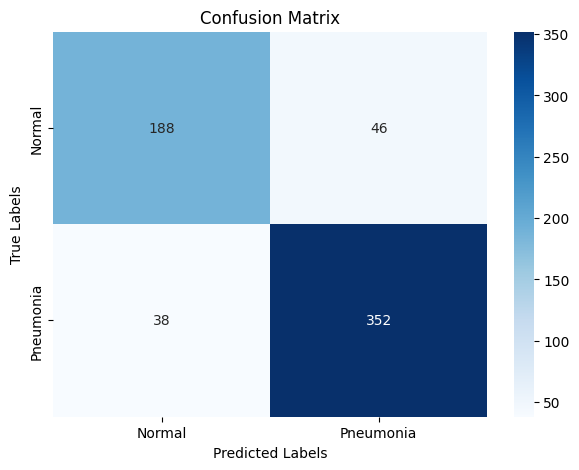

Per-class Accuracy:
Class Normal: 0.8034
Class Pneumonia: 0.9026

Results:
                                               model  test_accuracy  \
0                                       baseline DNN       0.834936   
1                                       baseline CNN       0.866987   
2  CNN experiment with 256 filters, dropout, and ...       0.865385   

   train_accuracy  val_accuracy  
0        0.942863      0.954198  
1        0.970263      0.965649  
2        0.941164      0.887405  


In [31]:
test_model_and_evaluate(model, "CNN experiment with 256 filters, dropout, and a 256 node dense layer") # Test Accuracy: 0.8654

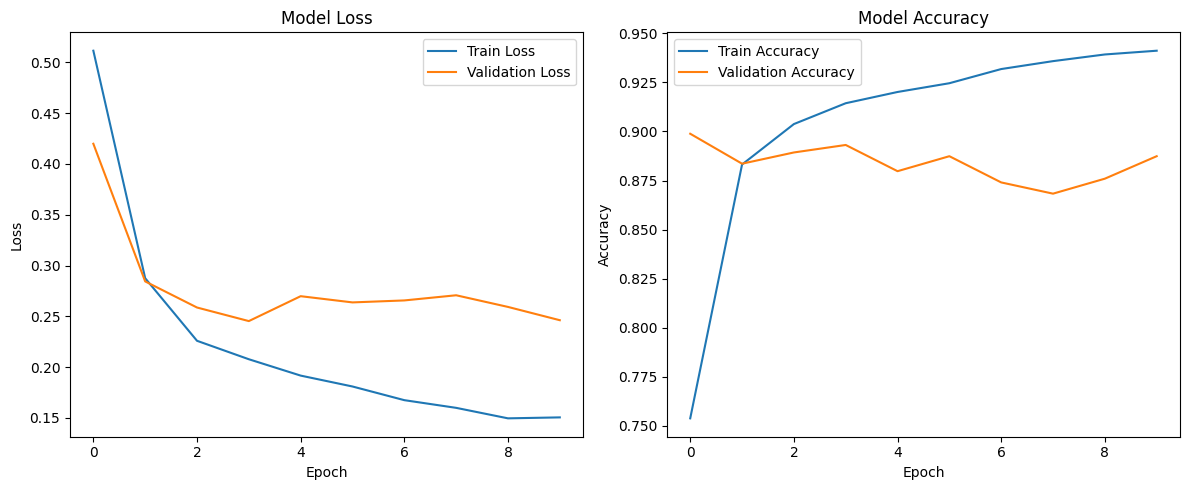

In [32]:
print_accuracy_and_loss(history)

In [33]:
# To GitHub Copilot Chat:
# "This model is not generalizing well to the validation set."

# From GitHub Copilot Chat:
#To improve generalization to the validation set, you can try the following strategies:
#Regularization: Add L2 regularization to the dense layers to prevent overfitting.
#Data Augmentation: Apply transformations like rotation, flipping, and zooming to the training data to make the model robust.
#Learning Rate Adjustment: Use a learning rate scheduler to reduce the learning rate as training progresses.
#Early Stopping: Monitor validation loss and stop training when it stops improving.
#Batch Normalization: Add batch normalization layers after convolutional layers to stabilize training.
#Would you like me to implement these changes in the model?

# To GitHub Copilot Chat:
#Yes, add a new experiment to try these

# Data Augmentation
image_gen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True
)

augmented_train = image_gen.flow(x_train, y_train, batch_size=32)

# Model with Regularization and Batch Normalization
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1), kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Flatten(),
    Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=0.0001),
    metrics=['accuracy']
)

# Callbacks for Early Stopping and Learning Rate Reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 26, 26, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 24, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 24, 24, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 10, 10, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 10, 10, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 5, 5, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 5, 5, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 3200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 256)            │       819,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 913,281 (3.48 MB)

 Trainable params: 912,833 (3.48 MB)

 Non-trainable params: 448 (1.75 KB)

In [34]:
history = model.fit(
    augmented_train,
    epochs=40,
    validation_data=(x_validation, y_validation),
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/40
148/148 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.7956 - loss: 6.4366 - val_accuracy: 0.7424 - val_loss: 5.8530 - learning_rate: 1.0000e-04
Epoch 2/40
148/148 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.8758 - loss: 5.4314 - val_accuracy: 0.7424 - val_loss: 5.6356 - learning_rate: 1.0000e-04
Epoch 3/40
148/148 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.8924 - loss: 4.7899 - val_accuracy: 0.7557 - val_loss: 4.8610 - learning_rate: 1.0000e-04
Epoch 4/40
148/148 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.8934 - loss: 4.2910 - val_accuracy: 0.9466 - val_loss: 3.8732 - learning_rate: 1.0000e-04
Epoch 5/40
148/148 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.8935 - loss: 3.8501 - val_accuracy: 0.9427 - val_loss: 3.4706 - learning_rate: 1.0000e-04
Epoch 6/40
148/148 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.9055 - loss: 3.4589 - val_accuracy: 0.8702 - val_loss: 3.2477 - learning_rate: 1.0000e-04
Epoch 7/40
148/148 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - acc

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Predicted probabilities shape: (624, 1)
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8901 - loss: 0.5494
Test Loss: 0.5471
Test Accuracy: 0.8798
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.71      0.82       234
           1       0.85      0.98      0.91       390

    accuracy                           0.88       624
   macro avg       0.90      0.85      0.86       624
weighted avg       0.89      0.88      0.88       624



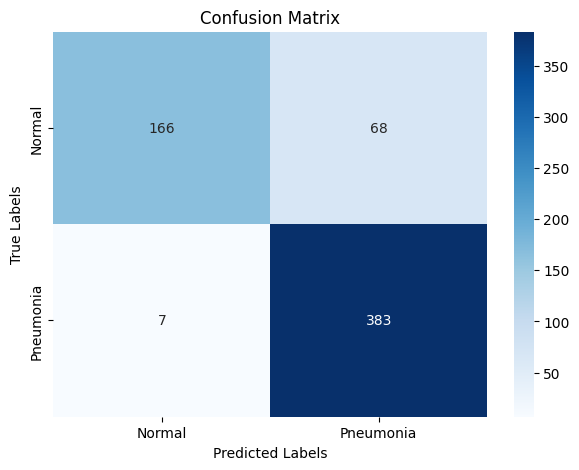

Per-class Accuracy:
Class Normal: 0.7094
Class Pneumonia: 0.9821

Results:
                                               model  test_accuracy  \
0                                       baseline DNN       0.834936   
1                                       baseline CNN       0.866987   
2  CNN experiment with 256 filters, dropout, and ...       0.865385   
3  CNN with image rotation, shift, zoom, and hori...       0.879808   

   train_accuracy  val_accuracy  
0        0.942863      0.954198  
1        0.970263      0.965649  
2        0.941164      0.887405  
3        0.950935      0.948473  


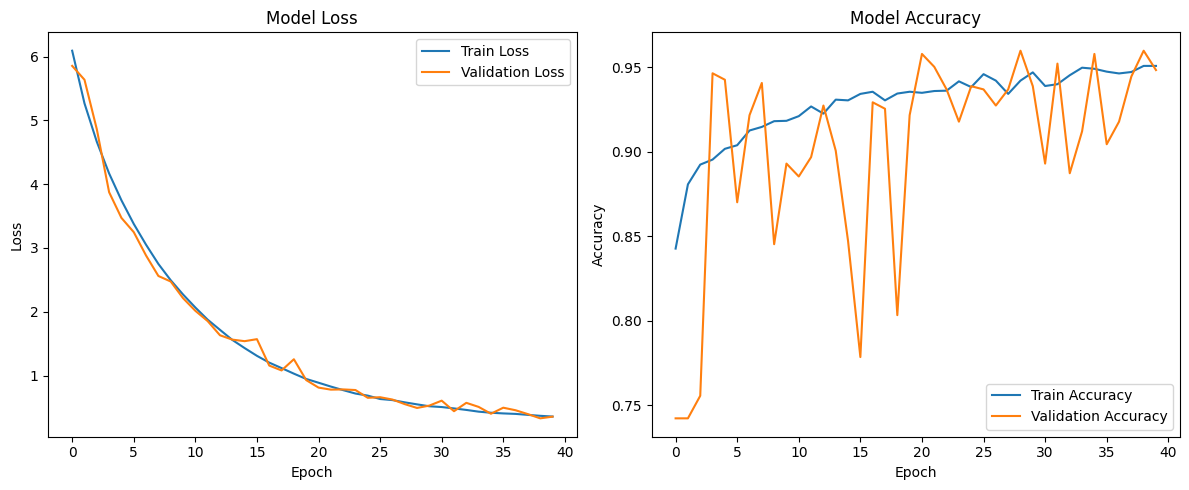

In [35]:
test_model_and_evaluate(model, "CNN with image rotation, shift, zoom, and horizontal flip") # Test Accuracy: 0.8798
print_accuracy_and_loss(history)

In [36]:
# Same as model just above, but this experiment will use x_train again during .fit() instead of modified images in augmented_train.
# # Model with Regularization and Batch Normalization
# model = Sequential([
#     Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1), kernel_regularizer=tf.keras.regularizers.l2(0.01)),
#     BatchNormalization(),
#     Conv2D(64, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
#     BatchNormalization(),
#     MaxPooling2D(pool_size=(2, 2)),
#     Dropout(0.25),

#     Conv2D(128, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
#     BatchNormalization(),
#     MaxPooling2D(pool_size=(2, 2)),
#     Dropout(0.25),

#     Flatten(),
#     Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
#     Dropout(0.5),
#     Dense(1, activation='sigmoid')
# ])

# model.compile(
#     loss='binary_crossentropy',
#     optimizer=Adam(learning_rate=0.0001),
#     metrics=['accuracy']
# )

# # Callbacks for Early Stopping and Learning Rate Reduction
# early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 26, 26, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 24, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 24, 24, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 10, 10, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 10, 10, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 5, 5, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 5, 5, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 3200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 256)            │       819,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,738,949 (10.45 MB)

 Trainable params: 912,833 (3.48 MB)

 Non-trainable params: 448 (1.75 KB)

 Optimizer params: 1,825,668 (6.96 MB)

In [37]:
history = model.fit(
    x_train, # using x_train again instead of modified images in augmented_train
    y_train,
    epochs=40,
    validation_data=(x_validation, y_validation),
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/40
148/148 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.9618 - loss: 0.3264 - val_accuracy: 0.9580 - val_loss: 0.3330 - learning_rate: 1.0000e-04
Epoch 2/40
148/148 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.9736 - loss: 0.2958 - val_accuracy: 0.9695 - val_loss: 0.2851 - learning_rate: 1.0000e-04
Epoch 3/40
148/148 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.9750 - loss: 0.2764 - val_accuracy: 0.9714 - val_loss: 0.2740 - learning_rate: 1.0000e-04
Epoch 4/40
148/148 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.9739 - loss: 0.2664 - val_accuracy: 0.9637 - val_loss: 0.2837 - learning_rate: 1.0000e-04
Epoch 5/40
148/148 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.9758 - loss: 0.2484 - val_accuracy: 0.9676 - val_loss: 0.2583 - learning_rate: 1.0000e-04
Epoch 6/40
148/148 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.9804 - loss: 0.2284 - val_accuracy: 0.9618 - val_loss: 0.2670 - learning_rate: 1.0000e-04
Epoch 7/40
148/148 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - acc

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Predicted probabilities shape: (624, 1)
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8811 - loss: 0.7537
Test Loss: 0.6749
Test Accuracy: 0.8782
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.68      0.81       234
           1       0.84      1.00      0.91       390

    accuracy                           0.88       624
   macro avg       0.92      0.84      0.86       624
weighted avg       0.90      0.88      0.87       624



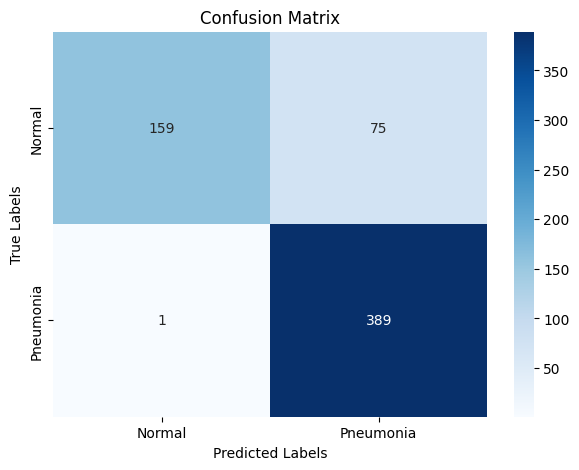

Per-class Accuracy:
Class Normal: 0.6795
Class Pneumonia: 0.9974

Results:
                                               model  test_accuracy  \
0                                       baseline DNN       0.834936   
1                                       baseline CNN       0.866987   
2  CNN experiment with 256 filters, dropout, and ...       0.865385   
3  CNN with image rotation, shift, zoom, and hori...       0.879808   
4              CNN experiment with L2 and batch norm       0.878205   

   train_accuracy  val_accuracy  
0        0.942863      0.954198  
1        0.970263      0.965649  
2        0.941164      0.887405  
3        0.950935      0.948473  
4        0.999788      0.975191  


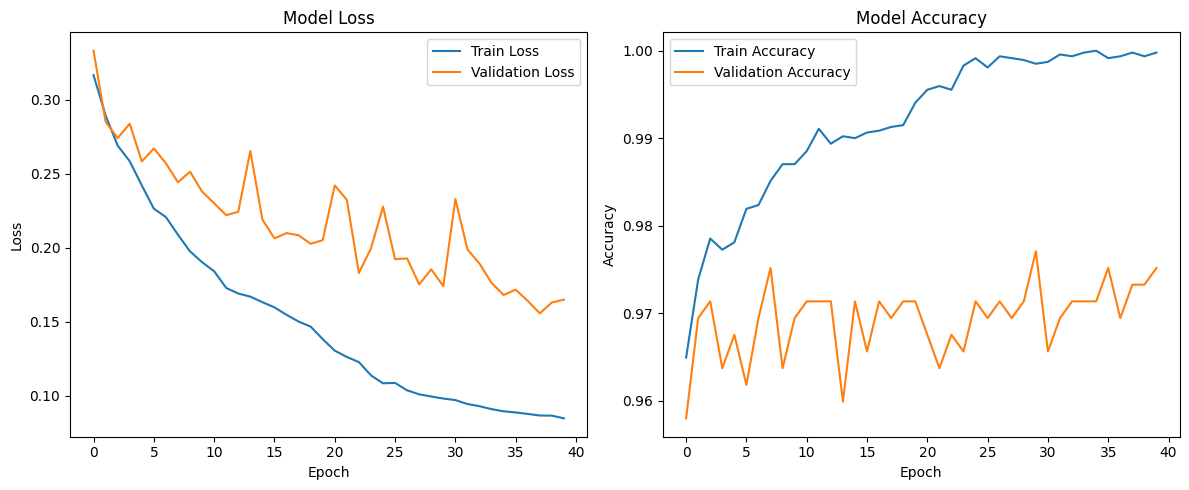

In [38]:
test_model_and_evaluate(model, "CNN experiment with L2 and batch norm") # Test Accuracy: 0.8782
print_accuracy_and_loss(history)

len(y_train) = 4708
np.sum(y_train == 0) = np.int64(1214)
np.sum(y_train == 1) = np.int64(3494)
Class weights: {0: np.float64(1.9390444810543657), 1: np.float64(0.6737263880938752)}
Epoch 1/40
148/148 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.9993 - loss: 0.0873 - val_accuracy: 0.9695 - val_loss: 0.1712 - learning_rate: 1.2500e-05
Epoch 2/40
148/148 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.9980 - loss: 0.0872 - val_accuracy: 0.9695 - val_loss: 0.2027 - learning_rate: 1.2500e-05
Epoch 3/40
148/148 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.9998 - loss: 0.0856 - val_accuracy: 0.9676 - val_loss: 0.1633 - learning_rate: 1.2500e-05
Epoch 4/40
148/148 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.9998 - loss: 0.0840 - val_accuracy: 0.9714 - val_loss: 0.1666 - learning_rate: 1.2500e-05
Epoch 5/40
148/148 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.9993 - loss: 0.0840 - val_accuracy: 0.9733 - val_loss: 0.1791 - learning_rate: 1.2500e-05
Epoch 6/40
148/148 ━━━━━━━━━━━━━━

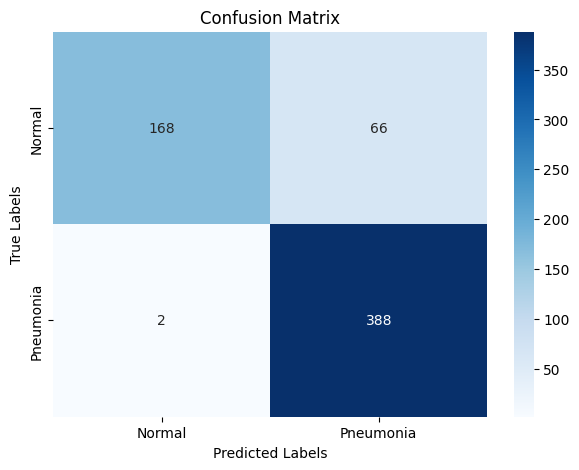

Per-class Accuracy:
Class Normal: 0.7179
Class Pneumonia: 0.9949

Results:
                                               model  test_accuracy  \
0                                       baseline DNN       0.834936   
1                                       baseline CNN       0.866987   
2  CNN experiment with 256 filters, dropout, and ...       0.865385   
3  CNN with image rotation, shift, zoom, and hori...       0.879808   
4              CNN experiment with L2 and batch norm       0.878205   
5  CNN with class weights {0: np.float64(1.939044...       0.891026   

   train_accuracy  val_accuracy  
0        0.942863      0.954198  
1        0.970263      0.965649  
2        0.941164      0.887405  
3        0.950935      0.948473  
4        0.999788      0.975191  
5        0.999788      0.969466  


In [39]:
# To GitHub Copilot Chat:
# Why is this model generalizing fine for validation, but failing to ever predict the normal cases properly?

# From GitHub Copilot Chat:
# Class Imbalance: If the training data has a significant imbalance between normal and pneumonia cases, 
# the model might become biased toward predicting the majority class. 
# Check the class distribution in the training, validation, and test sets to ensure they are balanced.

# Add class weighting to address imbalance
class_weights = {
    0: len(y_train) / (2 * np.sum(y_train == 0)),
    1: len(y_train) / (2 * np.sum(y_train == 1))
}
print(f"{len(y_train) = }")
print(f"{np.sum(y_train == 0) = }")
print(f"{np.sum(y_train == 1) = }")
print("Class weights:", class_weights)

# Retrain the model with class weights
history = model.fit(
    x_train,
    y_train,
    epochs=40,
    validation_data=(x_validation, y_validation),
    class_weight=class_weights,
    callbacks=[early_stopping, reduce_lr]
 )

# Evaluate the model again
test_model_and_evaluate(model, f"CNN with class weights {class_weights}") # Test Accuracy: 0.8910

Adjusted class weights: {0: 10, 1: 1.0}
Epoch 1/40
148/148 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.9992 - loss: 0.0918 - val_accuracy: 0.9695 - val_loss: 0.1905 - learning_rate: 6.2500e-06
Epoch 2/40
148/148 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.9993 - loss: 0.0906 - val_accuracy: 0.9676 - val_loss: 0.2015 - learning_rate: 6.2500e-06
Epoch 3/40
148/148 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.9987 - loss: 0.0879 - val_accuracy: 0.9676 - val_loss: 0.1874 - learning_rate: 6.2500e-06
Epoch 4/40
148/148 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 1.0000 - loss: 0.0863 - val_accuracy: 0.9542 - val_loss: 0.2561 - learning_rate: 6.2500e-06
Epoch 5/40
148/148 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.9990 - loss: 0.0880 - val_accuracy: 0.9714 - val_loss: 0.1938 - learning_rate: 6.2500e-06
Epoch 6/40
148/148 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.9990 - loss: 0.0877 - val_accuracy: 0.9695 - val_loss: 0.2002 - learning_rate: 6.2500e-06
Epoch 7/40
148/148

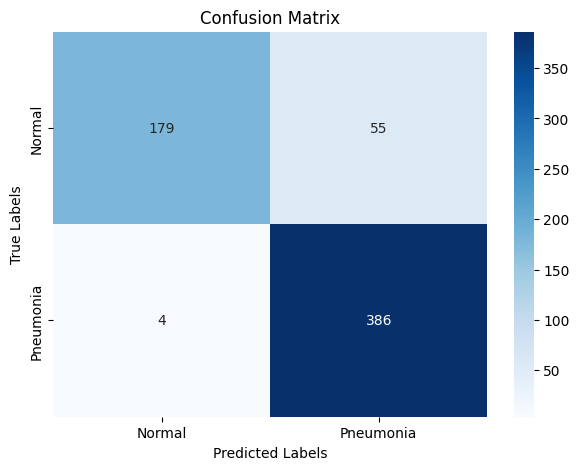

Per-class Accuracy:
Class Normal: 0.7650
Class Pneumonia: 0.9897

Results:
                                               model  test_accuracy  \
0                                       baseline DNN       0.834936   
1                                       baseline CNN       0.866987   
2  CNN experiment with 256 filters, dropout, and ...       0.865385   
3  CNN with image rotation, shift, zoom, and hori...       0.879808   
4              CNN experiment with L2 and batch norm       0.878205   
5  CNN with class weights {0: np.float64(1.939044...       0.891026   
6    CNN with adjusted class weights {0: 10, 1: 1.0}       0.905449   

   train_accuracy  val_accuracy  
0        0.942863      0.954198  
1        0.970263      0.965649  
2        0.941164      0.887405  
3        0.950935      0.948473  
4        0.999788      0.975191  
5        0.999788      0.969466  
6        0.999363      0.969466  


In [40]:
class_weights = {
    0: 10,
    1: 1.0
}
print("Adjusted class weights:", class_weights)

# Retrain the model with adjusted class weights
history = model.fit(
    x_train,
    y_train,
    epochs=40,
    validation_data=(x_validation, y_validation),
    class_weight=class_weights,
    callbacks=[early_stopping, reduce_lr]
 )

# Evaluate the model again
test_model_and_evaluate(model, f"CNN with adjusted class weights {class_weights}") # Test Accuracy: 0.9054

In [41]:
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))
print(f"Class weights: {class_weights}")

Class weights: {0: np.float64(1.9390444810543657), 1: np.float64(0.6737263880938752)}


In [42]:
def binary_focal_loss(gamma=2.0, alpha=0.15):
    def focal_loss(y_true, y_pred):
        y_pred = K.clip(y_pred, K.epsilon(), 1. - K.epsilon())
        pt = tf.where(tf.equal(y_true, 1), y_pred, 1 - y_pred)
        alpha_t = tf.where(tf.equal(y_true, 1), alpha, 1 - alpha)
        loss = -alpha_t * K.pow(1. - pt, gamma) * K.log(pt)
        return K.mean(loss)
    return focal_loss

In [43]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(28,28,1),
           kernel_regularizer=regularizers.l2(0.005)),  
    BatchNormalization(),
    MaxPooling2D(),
    Dropout(0.4), 
    Conv2D(64, (3,3), activation='relu', padding='same',
           kernel_regularizer=regularizers.l2(0.005)),  
    BatchNormalization(),
    MaxPooling2D(),
    Dropout(0.4),
    Flatten(),
    Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.005)), 
    Dropout(0.6), 
    Dense(1, activation='sigmoid')
])
model.compile(
    optimizer=Adam(learning_rate=0.0005), 
    loss=binary_focal_loss(gamma=2.0, alpha=0.15),
    metrics=['accuracy']
)
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 64)             │       200,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 220,033 (859.50 KB)

 Trainable params: 219,841 (858.75 KB)

 Non-trainable params: 192 (768.00 B)

In [44]:
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)
datagen.fit(x_train)

In [45]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, verbose=1, min_lr=1e-6)
history = model.fit(
    datagen.flow(x_train, y_train, batch_size=64),
    # steps_per_epoch=len(x_train) // 64, # commenting this prevented a warning message about not enough data in batch.
    epochs=40,
    validation_data=(x_validation, y_validation),
    class_weight=class_weights,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/40
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.5460 - loss: 1.0014 - val_accuracy: 0.7424 - val_loss: 0.7428 - learning_rate: 5.0000e-04
Epoch 2/40
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.6457 - loss: 0.6331 - val_accuracy: 0.7424 - val_loss: 0.7224 - learning_rate: 5.0000e-04
Epoch 3/40
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.7522 - loss: 0.4802 - val_accuracy: 0.7424 - val_loss: 0.7357 - learning_rate: 5.0000e-04
Epoch 4/40
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.7778 - loss: 0.3708 - val_accuracy: 0.7424 - val_loss: 0.6508 - learning_rate: 5.0000e-04
Epoch 5/40
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.7745 - loss: 0.2918 - val_accuracy: 0.7462 - val_loss: 0.5530 - learning_rate: 5.0000e-04
Epoch 6/40
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.7888 - loss: 0.2308 - val_accuracy: 0.8263 - val_loss: 0.2770 - learning_rate: 5.0000e-04
Epoch 7/40
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.8075 

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Predicted probabilities shape: (624, 1)
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9005 - loss: 0.0424
Test Loss: 0.0444
Test Accuracy: 0.9022
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.88      0.87       234
           1       0.93      0.91      0.92       390

    accuracy                           0.90       624
   macro avg       0.89      0.90      0.90       624
weighted avg       0.90      0.90      0.90       624



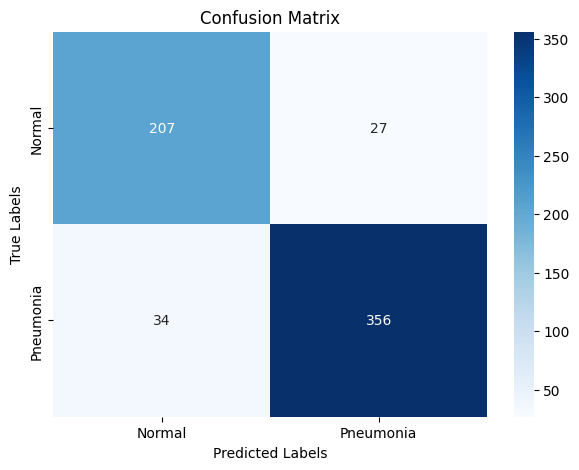

Per-class Accuracy:
Class Normal: 0.8846
Class Pneumonia: 0.9128

Results:
                                               model  test_accuracy  \
0                                       baseline DNN       0.834936   
1                                       baseline CNN       0.866987   
2  CNN experiment with 256 filters, dropout, and ...       0.865385   
3  CNN with image rotation, shift, zoom, and hori...       0.879808   
4              CNN experiment with L2 and batch norm       0.878205   
5  CNN with class weights {0: np.float64(1.939044...       0.891026   
6    CNN with adjusted class weights {0: 10, 1: 1.0}       0.905449   
7                         CNN with binary focal loss       0.902244   

   train_accuracy  val_accuracy  
0        0.942863      0.954198  
1        0.970263      0.965649  
2        0.941164      0.887405  
3        0.950935      0.948473  
4        0.999788      0.975191  
5        0.999788      0.969466  
6        0.999363      0.969466  
7        0.89

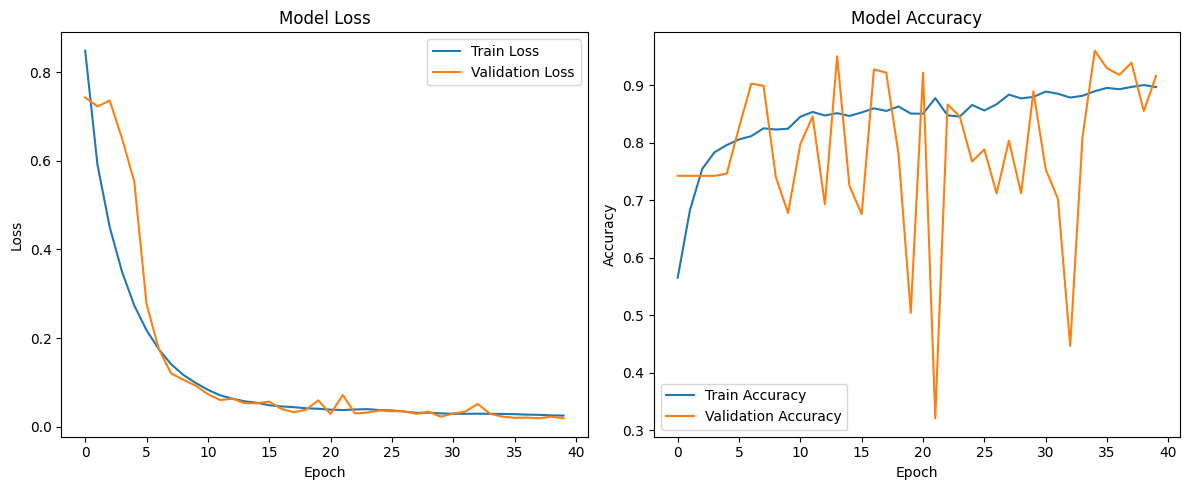

In [46]:
test_model_and_evaluate(model, "CNN with binary focal loss") # with python random.seed(42), after Jupyter kernel restart: Test Accuracy: 0.8926
print_accuracy_and_loss(history)